In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pybedtools import BedTool as pbt
import numpy as np

In [2]:
dots_df_HCplus_10_ext= pd.read_csv("/tank/projects/diana_hic/loops/loops_results/dots_df_HCplus_10_ext_maps112022.tsv", sep="\t")
dots_df_HCplus_10_ext["cell_type"] = "NeuN+"
dots_df_HCmin_10_ext= pd.read_csv("/tank/projects/diana_hic/loops/loops_results/dots_df_HCmin_10_ext_maps112022.tsv",  sep="\t")
dots_df_HCmin_10_ext["cell_type"] = "NeuN-"
all_loops_10_ext = pd.concat([dots_df_HCplus_10_ext[["chrom1", "start1", "end1", "chrom2", "start2","end2", "loop_length_mb", "cell_type"]],
                              dots_df_HCmin_10_ext[["chrom1", "start1", "end1", "chrom2", "start2","end2", "loop_length_mb", "cell_type"]]]).drop_duplicates().reset_index(drop=True)

### 1. Loop length

Text(0.5, 0, 'Cell type')

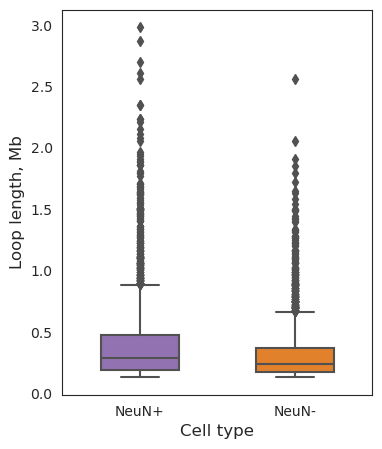

In [14]:
sns.set_style("white")
plt.figure(figsize=(4,5))
my_pal = {"NeuN+": sns.color_palette()[4], "NeuN-":sns.color_palette()[1]}
ax= sns.boxplot(data=all_loops_10_ext, x="cell_type", y="loop_length_mb",  width=0.5,
                showmeans=False, palette=my_pal, 
                meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},
#            order=["neurons_cooltools", "glia_cooltools", "neurons_mustache", "glia_mustache"]
               );
plt.ylabel("Loop length, Mb", size=12)
# plt.title("Loops found in the TAD borders (separated by 1 or 2 TADs)", size=12)
plt.xlabel("Cell type", size=12)

### Loops with CTCF

In [3]:
def intersect_with_feature_per_anhor(df,target_enhancer_genes_sloped1bin):
    intersect = pbt.from_dataframe(df).intersect(pbt.from_dataframe(target_enhancer_genes_sloped1bin), wa=True, wb=True)
    intersect = pd.read_table(intersect.fn, header = None , names = df.columns.tolist() +target_enhancer_genes_sloped1bin.columns.tolist()  )
    return intersect


def debpe2bep(df):
    df1 = df.drop(columns = ["chrom2","start2","end2"])
    df1["anhor"] = "right"
    df2 = df.drop(columns = ["chrom1","start1","end1"])
    df2["anhor"] = "left"
    df2.rename(columns = {"chrom2":"chrom","start2":"start","end2":"end"}, inplace=True)
    df1.rename(columns = {"chrom1":"chrom","start1":"start","end1":"end"}, inplace=True)
    df3= pd.concat([df1,df2]).reset_index(drop=True)
    assert df.shape[0]*2 == df3.shape[0]
    return df3

def make_column(dots_df_HCplus_10_ext, loops_ctcf_plus):
    ctcf_status = []
    for loop_num in dots_df_HCplus_10_ext.loop_num.tolist():
        if loop_num in loops_ctcf_plus.loop_num.tolist():
            # ctcf_status.append("has_ctcf_peak")
            unique = loops_ctcf_plus[loops_ctcf_plus.loop_num == loop_num].anhor.unique().tolist()            
            if "left" in unique and "right" in unique:
                ctcf_status.append("both")
            elif "left" in unique:
                ctcf_status.append("left")
            elif "right" in unique:
                ctcf_status.append("right")
            else:
               raise ValueError("Neither 'left' nor 'right' found in unique")
            
        else:
            ctcf_status.append("no_ctcf_peak")
    return ctcf_status
    
def make_intersection(df_init, target_enhancer_genes_sloped1bin):    
    df = debpe2bep(df_init)
    df_intersect = intersect_with_feature_per_anhor(df, target_enhancer_genes_sloped1bin)
    ctcf_status = make_column(df_init, df_intersect)
    # print(f"{df_intersect[feature_column].nunique()} {feature_column} per {df_init.loop_num.nunique()} loops in {name}")
    return ctcf_status


def slop_feature_bed(target_enhancer_genes_sloped1bin):   
    # target_enhancer_genes_sloped1bin.rename(columns = {"chr":"chr_feature","start":"start_feature","end":"end_feature"}, inplace=True)
    target_enhancer_genes_sloped1bin_pbt = pbt.from_dataframe(target_enhancer_genes_sloped1bin).slop(b=15_000, g="/tank/projects/diana_chipseq/cutrun/nx_run_all/supporting_files/hg38.chrom.sizes.txt")
    target_enhancer_genes_sloped1bin = pd.read_table(target_enhancer_genes_sloped1bin_pbt.fn, header = None , names = target_enhancer_genes_sloped1bin.columns )
    return target_enhancer_genes_sloped1bin

In [4]:
def prep_ctcf(path2file = "/tank/projects/schizophrenia_2021/data/ENCODE/ChIP-seq.CTCF.glutamatergic_neurons.peaks.ENCFF579WDY.bed.gz"):
    ctcf_peaks_neurons = pd.read_csv(path2file, sep = "\t", header= None)
    ctcf_peaks_neurons["width"] = ctcf_peaks_neurons[2] - ctcf_peaks_neurons[1]
    ctcf_peaks_neurons = ctcf_peaks_neurons.sort_values([0,1,2]).reset_index(drop=True)
    ctcf_peaks_neurons = ctcf_peaks_neurons.iloc[:, :3]
    ctcf_peaks_neurons.columns = ["chr_ctcf","start_ctcf","end_ctcf"]
    ctcf_peaks_neurons = slop_feature_bed(ctcf_peaks_neurons)
    return ctcf_peaks_neurons

ctcf_peaks_not_neurons = prep_ctcf(path2file = "/tank/projects/schizophrenia_2021/data/ENCODE/ChIP-seq.CTCF.astrocytes.peaks.ENCFF896MXI.bed.gz")
ctcf_peaks_neurons = prep_ctcf(path2file = "/tank/projects/schizophrenia_2021/data/ENCODE/ChIP-seq.CTCF.glutamatergic_neurons.peaks.ENCFF579WDY.bed.gz")

In [5]:
loops_ctcf_plus = make_intersection(dots_df_HCplus_10_ext, ctcf_peaks_neurons)
dots_df_HCplus_10_ext["ctcf_peak"] = loops_ctcf_plus
dots_df_HCplus_10_ext.replace("right", "one_anchor", inplace=True)
dots_df_HCplus_10_ext.replace("left", "one_anchor", inplace=True)

In [10]:
loops_ctcf_minus = make_intersection(dots_df_HCmin_10_ext, ctcf_peaks_not_neurons)
dots_df_HCmin_10_ext["ctcf_peak"] = loops_ctcf_minus
dots_df_HCmin_10_ext.replace("right", "one_anchor", inplace=True)
dots_df_HCmin_10_ext.replace("left", "one_anchor", inplace=True)

In [11]:
from collections import Counter
Counter(loops_ctcf_plus), Counter(loops_ctcf_minus)

(Counter({'both': 2176, 'right': 180, 'left': 200, 'no_ctcf_peak': 67}),
 Counter({'right': 585, 'left': 574, 'both': 1468, 'no_ctcf_peak': 397}))

In [12]:
all_loops_10_ext = pd.concat([dots_df_HCplus_10_ext[["chrom1", "start1", "end1", "chrom2", "start2","end2", "loop_length_mb", "cell_type", "ctcf_peak"]],
                              dots_df_HCmin_10_ext[["chrom1", "start1", "end1", "chrom2", "start2","end2", "loop_length_mb", "cell_type", "ctcf_peak"]]]).drop_duplicates().reset_index(drop=True)

In [20]:
all_loops_10_ext_has_both_peaks = all_loops_10_ext[all_loops_10_ext.ctcf_peak == "both"].reset_index(drop=True)
all_loops_10_ext_has_no_peaks = all_loops_10_ext[all_loops_10_ext.ctcf_peak == "no_ctcf_peak"].reset_index(drop=True)
all_loops_10_ext_has_one_peaks = all_loops_10_ext[all_loops_10_ext.ctcf_peak == "one_anchor"].reset_index(drop=True)

In [21]:
from scipy.stats import mannwhitneyu

statistic, p_value = mannwhitneyu(all_loops_10_ext_has_no_peaks[all_loops_10_ext_has_no_peaks.cell_type == "NeuN+"].loop_length_mb.tolist(), 
                                  all_loops_10_ext_has_no_peaks[all_loops_10_ext_has_no_peaks.cell_type == "NeuN-"].loop_length_mb.tolist())
print("Statistic:", statistic)
print("p-value:", p_value)

Statistic: 11605.0
p-value: 0.09469607085189218


In [22]:
from scipy.stats import mannwhitneyu

statistic, p_value = mannwhitneyu(all_loops_10_ext_has_both_peaks[all_loops_10_ext_has_both_peaks.cell_type == "NeuN+"].loop_length_mb.tolist(), 
                                  all_loops_10_ext_has_both_peaks[all_loops_10_ext_has_both_peaks.cell_type == "NeuN-"].loop_length_mb.tolist())
print("Statistic:", statistic)
print("p-value:", p_value)

Statistic: 1812435.0
p-value: 4.74439541513879e-12


In [23]:
from scipy.stats import mannwhitneyu

statistic, p_value = mannwhitneyu(all_loops_10_ext_has_one_peaks[all_loops_10_ext_has_one_peaks.cell_type == "NeuN+"].loop_length_mb.tolist(), 
                                  all_loops_10_ext_has_one_peaks[all_loops_10_ext_has_one_peaks.cell_type == "NeuN-"].loop_length_mb.tolist())
print("Statistic:", statistic)
print("p-value:", p_value)

Statistic: 225376.0
p-value: 0.49172142080875936


In [24]:
all_loops_10_ext.groupby(["cell_type","ctcf_peak"]).size()

cell_type  ctcf_peak   
NeuN+      both            2176
           no_ctcf_peak      67
           one_anchor       380
NeuN-      both            1468
           no_ctcf_peak     397
           one_anchor      1159
dtype: int64

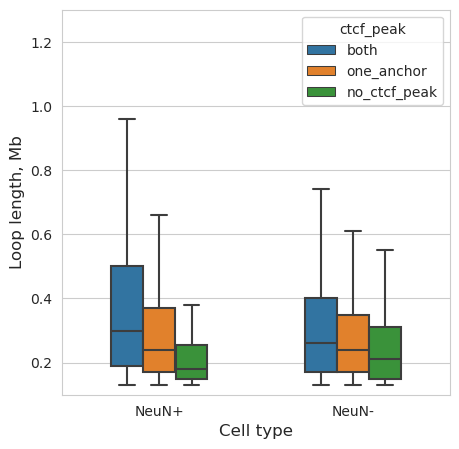

In [26]:
sns.set_style("whitegrid")
plt.figure(figsize=(5,5))
# my_pal = {"NeuN+": sns.color_palette()[4], "NeuN-":sns.color_palette()[1]}
ax= sns.boxplot(data=all_loops_10_ext, x="cell_type", y="loop_length_mb",  width=0.5,
                hue = "ctcf_peak", showmeans=False,  showfliers=False, 
                # palette=my_pal, 
                meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},
#            order=["neurons_cooltools", "glia_cooltools", "neurons_mustache", "glia_mustache"]
               );
plt.ylabel("Loop length, Mb", size=12)
plt.ylim(0.1, 1.3)
plt.xlabel("Cell type", size=12)
plt.savefig("/tank/projects/diana_hic/figs_hic_paper/figs_hic_paper_review/general_loops_length_separateOneBoth.pdf", format = "pdf", bbox_inches='tight', dpi =350)


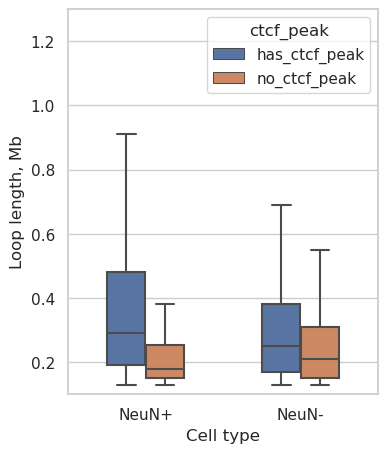

In [151]:
sns.set_style("whitegrid")
plt.figure(figsize=(4,5))
# my_pal = {"NeuN+": sns.color_palette()[4], "NeuN-":sns.color_palette()[1]}
ax= sns.boxplot(data=all_loops_10_ext, x="cell_type", y="loop_length_mb",  width=0.5,
                hue = "ctcf_peak", showmeans=False,  showfliers=False, 
                # palette=my_pal, 
                meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},
#            order=["neurons_cooltools", "glia_cooltools", "neurons_mustache", "glia_mustache"]
               );
plt.ylabel("Loop length, Mb", size=12)
plt.ylim(0.1, 1.3)
plt.xlabel("Cell type", size=12)
plt.savefig("/tank/projects/diana_hic/figs_hic_paper/figs_hic_paper_review/general_loops_length.pdf", format = "pdf", bbox_inches='tight', dpi =350)


## Compare with polycomb dots

In [81]:
pair_sites = pd.read_csv("/tank/projects/diana_hic/tads/tads_results/pair_sites_with_location_border60kb.csv")
pair_sites["anhor_center_left"] = (pair_sites["end1"] - pair_sites["start1"]) // 2+ pair_sites["start1"]
pair_sites["anhor_center_right"] = (pair_sites["end2"] - pair_sites["start2"]) // 2+pair_sites["start2"]
pair_sites["loop_length_mb"] = (pair_sites["anhor_center_right"] - pair_sites["anhor_center_left"])/ 1_000_000

In [152]:
def plot2lists(list1, list2, names):
    titles = [[names[0]]*len(list1)] + [[names[1]]*len(list2)]
    titles = [
    x
    for xs in titles
    for x in xs
]
    assert len(titles) == len(list1+list2)
    
    data = pd.DataFrame({
    'loop_length_mb': list1+list2,
    'loop_type': titles
    })
    data["log2_loop_length_mb"] = np.log2(data.loop_length_mb)
    plt.figure(figsize=(4,5))
    sns.set_theme(style="whitegrid")
    sns.boxplot(data=data, x = "loop_type", y="log2_loop_length_mb", width = 0.35, showfliers=False,
               showmeans=True, meanprops={"marker":"o","markerfacecolor":"white","markersize":"5"})
    plt.savefig("/tank/projects/diana_hic/figs_hic_paper/figs_hic_paper_review/polycomb_general_loops_length.pdf", format = "pdf", bbox_inches='tight', dpi =350)
    plt.show()
    
    return data

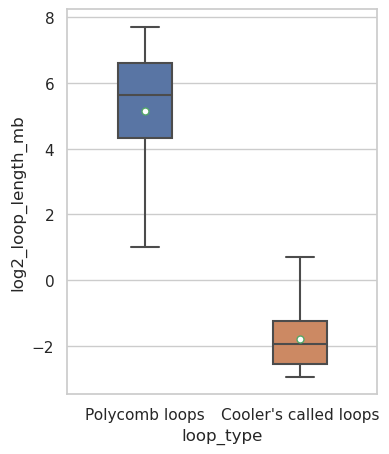

In [153]:
data = plot2lists(pair_sites["loop_length_mb"].tolist(), all_loops_10_ext["loop_length_mb"].tolist(), ["Polycomb loops", "Cooler's called loops"])